In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# reading the data into a pandas dataframe..

df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [3]:
df_train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.0
3,1DR6ROZ4,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0,1.0


In [4]:
df_test.tail()

,tweet_id,safe_text
5172,ZXVVNC5O,jenny mccarthy is on new years rockin eve. what has she done lately besides not vaccinate her kids and give us all goddamn polio??
5173,ZYIANVI8,Measles reported in Clark Co. for 1st time since 2011 <url>
5174,ZYITEHAH,"<user> issues alert regarding Measles in TX. Keep your DDx up to date, people! #Emergencymedicine"
5175,ZZ3BMBTG,I can't believe people don't vaccinate their kids! I've been vaccinated for everything and then some.
5176,ZZIYCVNH,"""<user> Alternatives to #Flu Vaccine <url> #natural #health"" A good read with a few new tips &amp; many we #jerf folk know"


In [5]:
# check for value counts so as to see the number of classes in the target/output variable..

df_train['label'].value_counts()

 0.000000    4908
 1.000000    4053
-1.000000    1038
 0.666667       1
Name: label, dtype: int64

This is a multiclass classification problem since there are more than two classes. Here we have 0, 1, -1, and 0.667.
But from the look of this dataset, we're supposed to predict between three(3) classes but we have four. This might be a data quality issue since the class 0.667 is not a valid class for this situation. It will be appropriate to remove that row from our dataset...

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


In [8]:
df_train.duplicated().sum(), df_train.isnull().sum()

(0,
 tweet_id     0
 safe_text    0
 label        1
 agreement    2
 dtype: int64)

In [9]:
df_test.duplicated().sum(), df_test.isnull().sum()

(0,
 tweet_id     0
 safe_text    1
 dtype: int64)

In [10]:

df_test[df_test['safe_text'].isna()]

,tweet_id,safe_text
2024,Dr. JAMES SHANNON,NaN


Clearly, tweet_id DR JAMES SHANNON is not a valid tweet_id and so it needs to be dropped from the datasets..

There seems to be few null values in both datasets.
let's first drop the null values..

In [11]:
df_train.dropna(axis=0, inplace=True)
df_test.dropna(axis=0, inplace=True)

In [12]:
df_train.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [13]:
df_test.isnull().sum()

tweet_id     0
safe_text    0
dtype: int64

In [14]:
df_train['label'].value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

So, it appears that the value consisting of the null and invalid tweet_id was the same row which had an invalid class of 0.666667. it's been removed.

Data cleaning of tweets
1. Tokenization
2. Removing stopwords, but in this case removing stopwords will be kinda disavantageous because stop words such as not, No will be needed to determine negative sentiments.
3. Removing punctautions
4. Lemmatization
5. Stemming
6. Part of speech tagging..
6. Vectorization (TFID vectorizer) and so on...

In [15]:
df_train[['safe_text','label']].loc[45]

safe_text    CDC eyeing bird flu vaccine for humans, though...
label                                                      0.0
Name: 45, dtype: object

In [16]:
df_train

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.000000
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0,1.000000
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.000000
3,1DR6ROZ4,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0,1.000000
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0,1.000000
...,...,...,...,...
9996,IU0TIJDI,Living in a time where the sperm I used to waste on Jenny McCarthy is doing better than some of the sperm that became kids. #vaccineswork,1.0,1.000000
9997,WKKPCJY6,"<user> <user> In spite of all measles outbreaks, judge in MI threatens to put father in jail if I vaccinate.",1.0,0.666667
9998,ST3A265H,Interesting trends in child immunization in Oklahoma from <user> covering the <user> meeting.,0.0,1.000000
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Decades: (<url> have returned in the U.S. to... <url>,0.0,1.000000


We dont need the tweet_id and the agreement columns so it'll be dropped..

In [17]:
df_train.drop(['tweet_id', 'agreement'], axis=1, inplace=True)

In [18]:
df_train

,safe_text,label
0,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0
1,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0
2,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0
3,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0
4,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0
...,...,...
9996,Living in a time where the sperm I used to waste on Jenny McCarthy is doing better than some of the sperm that became kids. #vaccineswork,1.0
9997,"<user> <user> In spite of all measles outbreaks, judge in MI threatens to put father in jail if I vaccinate.",1.0
9998,Interesting trends in child immunization in Oklahoma from <user> covering the <user> meeting.,0.0
9999,CDC Says Measles Are At Highest Levels In Decades: (<url> have returned in the U.S. to... <url>,0.0


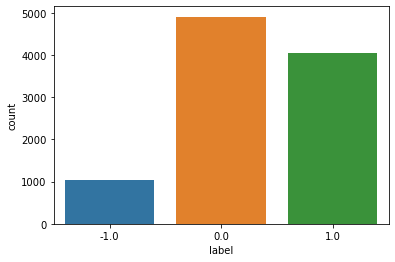

In [19]:
# Let's visualize the training dataset distribution..

sns.countplot(data=df_train, x='label');

The data is balance between the labels zeros(0's) and ones(1's) but with very few instances of neutral sentiments, which makes it unbalanced for anti-vaccine and pro-vaccine.
1 for pro vaccine(meaning they want the vaccine)
-1 for anti-vaccine(they don't want to vaccinate)
0 for neutral.
Since the dataset is imbalanced, let's handle that before we start processing the tweet text. We'll handle imbalance using the SMOTE(synthetic Minority Oversampling Technique). Below are the steps to following when using the SMOTE.
1. Choose a minority class as the input vector
2. Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
3. Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
4. Repeat the steps until data is balanced

In a text dataset, SMOTE can't be applied from the start unless we do the vectorization of text and then convert them to numbers so that we can do the SMOTE to handle imbalanced dataset.. This will be done later in this project after getting the converting text to vectors.

In [20]:
# Now, let's plot the word cloud of this dataset..


sentences_list = list(df_train['safe_text'])

In building the wordcloud, we'll use the nltk stopwords function to capture all the stopwords in the wordcloud..

In [21]:
df_train['safe_text'][5]

'<user> a nearly 67 year old study when mental health studies and vaccines were relatively in their infancies that has been refuted?'

In [22]:
from string import punctuation


stopwords = STOPWORDS
tokenizer = TweetTokenizer()


def process_text(sentence):
    
    # remove punctuations
    sentence = [i.lower() for i in sentence if i not in punctuation]
    # rejoin the characters to form back the string(tweet)
    sentence = ''.join(sentence)
    # tokeninze the tweets
    # remove non alphabets from tokens..
    sentence = tokenizer.tokenize(sentence)
    sentence = [i for i in sentence if i.isalpha()]
    
    # remove stopwords from the list..
    # sentence = [i for i in sentence if i not in stopwords]
    
    # perform stemming/lemmatization
    
    return sentence

In [23]:
test = 'I owe; everything! to GOD.'


In [24]:

test = [char for char in test if char not in punctuation]
test = ''.join(test)
test

'I owe everything to GOD'

In [25]:
df_train_clean = df_train['safe_text'].apply(lambda x: process_text(x)) 

In [26]:
df_train_clean

0        [me, amp, the, big, homie, meanboy, meanboy, m...
1        [im, thinking, of, devoting, my, career, to, p...
2        [whatcausesautism, vaccines, do, not, vaccinat...
3        [i, mean, if, they, immunize, my, kid, with, s...
4        [thanks, to, user, catch, me, performing, at, ...
                               ...                        
9996     [living, in, a, time, where, the, sperm, i, us...
9997     [user, user, in, spite, of, all, measles, outb...
9998     [interesting, trends, in, child, immunization,...
9999     [cdc, says, measles, are, at, highest, levels,...
10000    [pneumonia, vaccine, for, women, w, risk, of, ...
Name: safe_text, Length: 9999, dtype: object

In [27]:
sent = 'i used 100 cedis to board a cab'
process_text(sent)

['i', 'used', 'cedis', 'to', 'board', 'a', 'cab']

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# call the vectorizer and pass the text preprocessing function to it as the analyzer..
vectorizer = TfidfVectorizer(analyzer=process_text)
count_vectorizer = CountVectorizer()

In [29]:

tweets_vectorizer = vectorizer.fit_transform(df_train_clean)

In [30]:
vectorizer.get_feature_names_out()

array(['ababyjustdiedinncbcofwhoopingcoughsogladmostpplindustinsampmyfamilyhavealreadygottenthevaccinegottatakeprecautions',
       'ababywasbornonthejtrainthismorningcanwesafelyassumethatithasimmunitytoalldiseasesthataffecthumansandrats',
       'abigthankyouonbehalfofmeaslestoallthedummieswhodontimmunizetheirkids',
       ..., 'ºoºmaybeimmunizationmaybeitsautismºoº',
       'вкололитутмнеmmrпрививкуmeaslesmumpsrubellavaccineвбудущеесмотрюсоптимизмом',
       '病院実習行くのにmmrと水疱瘡の抗体を調べたらﾟдﾟ自分で保険会社に請求しろと言われた取り敢えず自己負担だね'],
      dtype=object)

In [31]:
# let's convert to matrix of vectors

train_X = tweets_vectorizer.toarray()

In [32]:
train_X.shape

(9999, 9569)

In [33]:
# let's create a new dataframe of these vectors.. as our training dataset..

train_X = pd.DataFrame(train_X)

In [34]:
train_X

,0,1,2,3,4,5,6,7,8,9,...,9559,9560,9561,9562,9563,9564,9565,9566,9567,9568
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
train_y = df_train['label']

In [36]:
train_y

0        0.0
1        1.0
2       -1.0
3       -1.0
4        0.0
        ... 
9996     1.0
9997     1.0
9998     0.0
9999     0.0
10000    1.0
Name: label, Length: 9999, dtype: float64

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.1)

In [38]:
from sklearn.naive_bayes import MultinomialNB

mnb_clf = MultinomialNB()

In [39]:
mnb_clf.fit(X_train, y_train)

MultinomialNB()

In [40]:
preds = mnb_clf.predict(X_test)

In [41]:
# convert list of sentences into a single sentence..

# all_sentences = ''.join(sentence.lower() for sentence in sentences_list)

In [46]:
stop_words = STOPWORDS

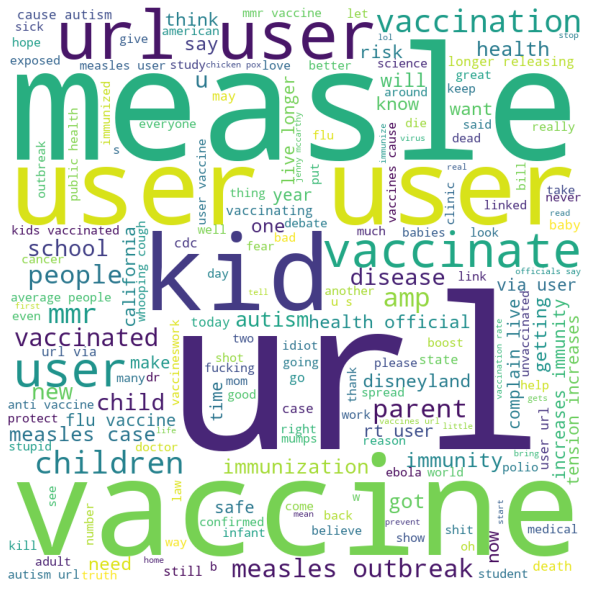

In [47]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(all_sentences)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

From the above wordcloud plotted, some of the most mentioned  words are measle, vaccinate, vaccine, case, flu, polio, kid, parent, people, school, immunization, health, longer, ebola, immunity, children, vaccinating, autism. Some of the words are not associated with the vaccination but are related to the witter platform. For instance, user, url, link, amp, via and so on..